In [1]:
import sys
sys.path.append("../../diffusion_models")
from models.sampler import DiffusionSampler
from models.unet import UNet
from models.diffusion import DiffusionModel, ForwardDiffusion
import torch
import torch.nn as nn
import os
import json
import torchvision
from time import time

config = None
with open("config_dutifulpond10.json", "r") as f:
    config = json.load(f)
ckpt_path = f"/home/lionel/Documents/checkpoints/dutiful-pond-10-checkpoint32.pt"
device = torch.device("cuda")
backbone = UNet(
    num_encoding_blocks = config["backbone_enc_depth"]["value"],
    in_channels = config["in_channels"]["value"],
    kernel_size = config["kernel_size"]["value"],
    time_emb_size = config["time_enc_dim"]["value"],
    dropout = 0.0,
    activation = nn.SiLU,
    verbose = False,
    init_channels = config["unet_init_channels"]["value"],
    attention = False
)
fwd_diff = ForwardDiffusion(
    timesteps = config["max_timesteps"]["value"],
    type = config["schedule_type"]["value"]
)
model = DiffusionModel(
    backbone = backbone,
    fwd_diff = fwd_diff,
    img_size = config["img_size"]["value"],
    time_enc_dim = config["time_enc_dim"]["value"]
)
sampler = DiffusionSampler(
    model,
    ckpt_path,
    "cuda",
    mixed_precision = True
).to(device)

In [2]:
time1 = time()
out = sampler.sample(16)
print(time() - time1)

Max Memory Allocated: 1.42
500.3839464187622


In [3]:
torch.save(out, "samples.obj")
out = torch.load("samples.obj")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


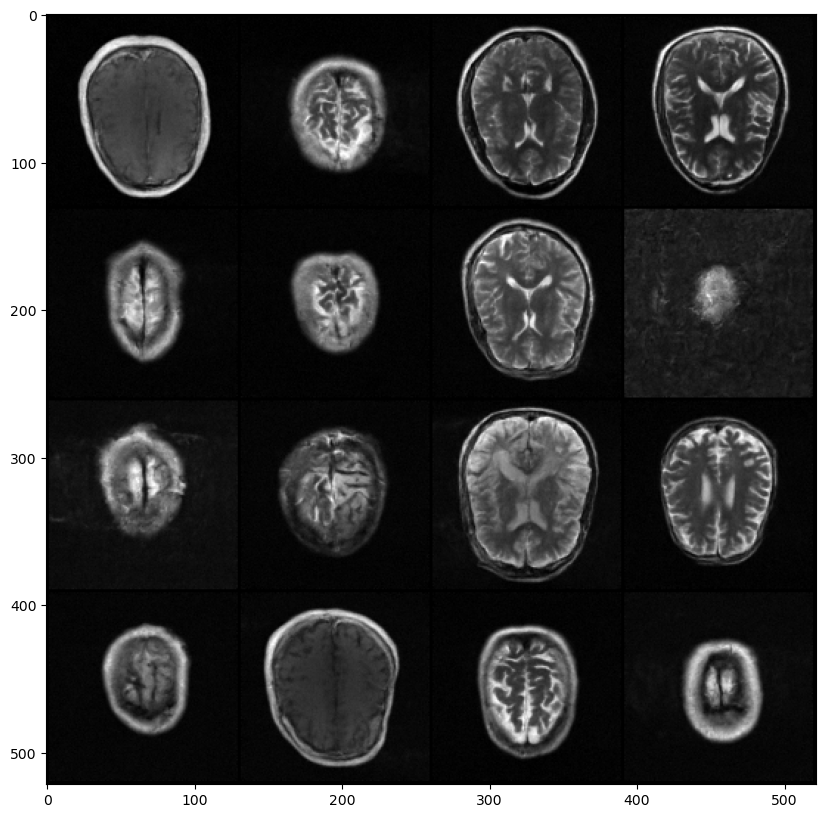

In [5]:
import matplotlib.pyplot as plt

out = out.to("cpu")
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(torchvision.utils.make_grid(out, nrow=4).permute(1,2,0))

In [15]:
out.shape

torch.Size([16, 1, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


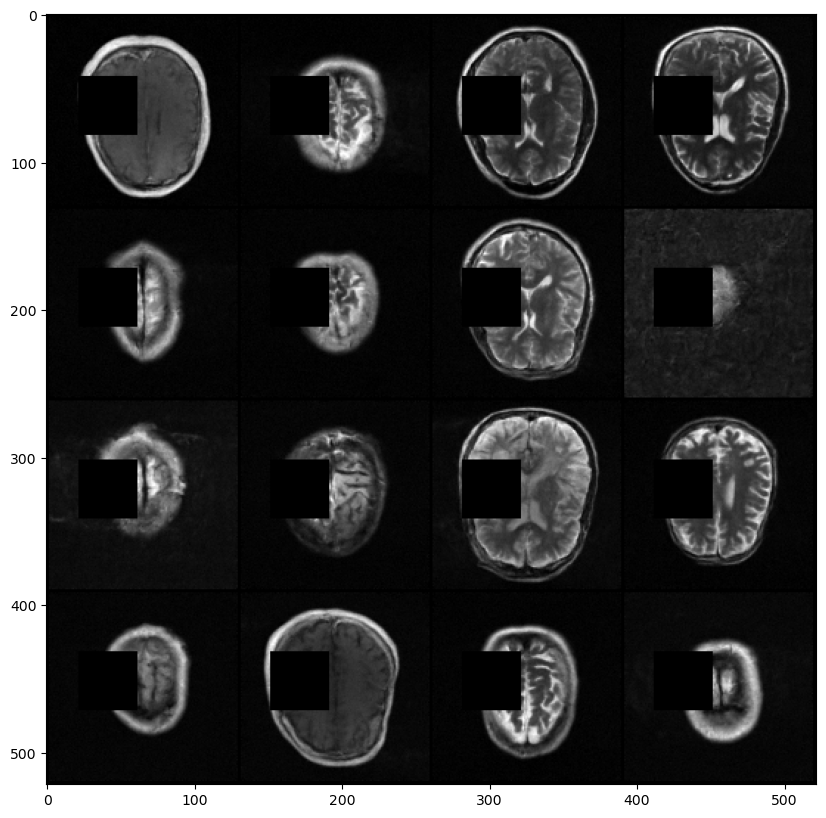

In [22]:
mask = torch.zeros(*out.shape, dtype=torch.bool)
mask[:, :, 40:80, 20:60] = 1

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(torchvision.utils.make_grid(out * ~mask, nrow=4).permute(1,2,0))

In [31]:
from jaxtyping import Float, Bool
from torch import Tensor

def no_resampling(img: Float[Tensor, "batch channel height width"], mask: Bool[Tensor, "batch 1 height width"]):
    """Different masks for different samples in the batch possible, but same mask for all channels of one sample."""
    mask = mask.to("cuda")
    beta = sampler.model.fwd_diff.betas[-1].view(-1,1,1,1)
    noise = sampler.model.init_noise(img.shape[0]) * torch.sqrt(beta) * mask
    # img,_ = sampler.model.fwd_diff(
    #     img.to("cuda"), 
    #     torch.tensor([sampler.model.fwd_diff.timesteps-1 for _ in range(img.shape[0])], dtype=torch.long, device=torch.device("cuda"))
    # )
    # img = img * ~mask
    # x = noise + img
    intermediates = []
    for i in reversed(range(1, sampler.model.fwd_diff.timesteps)):
        t = i * torch.ones((img.shape[0]), dtype=torch.long, device=torch.device("cuda"))
        x = sampler.model.denoise_singlestep(x, t)
        if i % 20 == 0:
            intermediates.append(x)
        # img,_ = sampler.model.fwd_diff(img, t - 1)
        # img = img * ~mask
        # x = x * mask
        # x = x + img
    return x, intermediates

out, inter = no_resampling(out, mask)

torch.Size([16, 1, 128, 128]) torch.Size([16, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


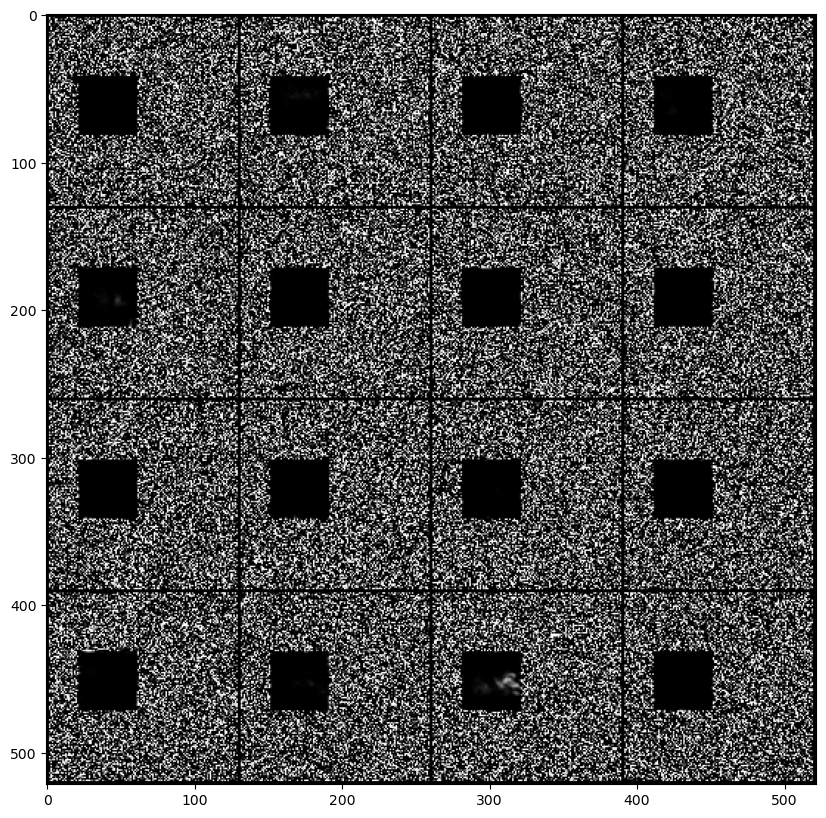

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(torchvision.utils.make_grid(out.cpu(), nrow=4).permute(1,2,0))

In [19]:
beta = sampler.model.fwd_diff.betas[-1].view(-1,1,1,1)
x = sampler.model.init_noise(4) * torch.sqrt(beta)
intermediates = []
for i in reversed(range(1, sampler.model.fwd_diff.timesteps)):
    t = i * torch.ones((4), dtype=torch.long, device=torch.device("cuda"))
    x = sampler.model.denoise_singlestep(x, t)
    if i % 20 == 0:
        intermediates.append(x)

In [1]:
intermediates2 = [torchvision.utils.make_grid(elem.cpu()) for elem in intermediates]
plt.imshow(torchvision.utils.make_grid(torch.stack(intermediates2)).permute(1,2,0))

NameError: name 'intermediates' is not defined